# Data Exploration for the German Traffic Signs

In [1]:
!pip install --quiet ipdb dicto # TODO: Add to the DockerFile instead of glueing here.

In [2]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dicto as do
import tensorflow as tf


In [3]:
with open("/data/train.p", "rb") as fd:
    train = pickle.load(fd)

In [4]:
print({key: value.shape for key, value in train.items()})

{'coords': (34799, 4), 'labels': (34799,), 'features': (34799, 32, 32, 3), 'sizes': (34799, 2)}


Let use what kind of image are we getting from the training data.

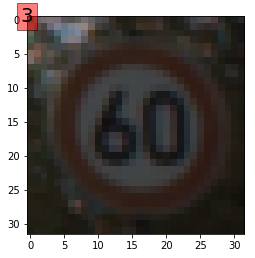

In [5]:
fig, ax = plt.subplots()
im = ax.imshow(train['features'][6535])
ax.text(0, 1, train['labels'][6535], fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

In [6]:
labels_df = pd.DataFrame(train['labels'], columns=['class_id'])
labels_df.groupby(['class_id']).size()

class_id
0      180
1     1980
2     2010
3     1260
4     1770
5     1650
6      360
7     1290
8     1260
9     1320
10    1800
11    1170
12    1890
13    1920
14     690
15     540
16     360
17     990
18    1080
19     180
20     300
21     270
22     330
23     450
24     240
25    1350
26     540
27     210
28     480
29     240
30     390
31     690
32     210
33     599
34     360
35    1080
36     330
37     180
38    1860
39     270
40     300
41     210
42     210
dtype: int64

In [7]:
print(labels_df.max(axis=0))
print(labels_df.min(axis=0))

class_id    42
dtype: uint8
class_id    0
dtype: uint8


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce6ffe4390>]], dtype=object)

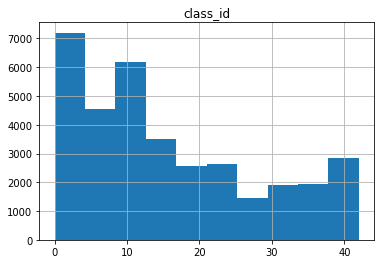

In [8]:
labels_df.hist()

In [9]:
from itertools import product
def make_indexes(tuple_index):
    rows, columns = tuple_index
    for index in product(range(rows), range(columns)):
        yield index

In [10]:
def plot_list(img_indexes, shape):
    try:
        grid = np.array(img_indexes).reshape(shape)
    except ValueError:
        grid = np.array(img_indexes + [-1]).reshape(shape)
    fig, axes = plt.subplots(*shape, figsize=(14, 10))
    for index in make_indexes(shape):
        img_index  = grid[index]
        img = train['features'][img_index]
        axes[index].set_title(train['labels'][img_index])
        axes[index].imshow(img)
        axes[index].set_axis_off()

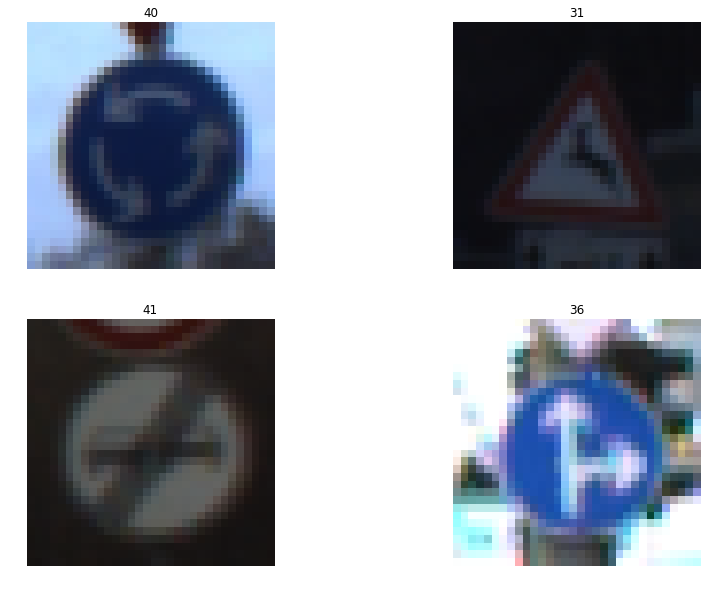

In [11]:
plot_list([4415,712,21, 1026], shape=(2,2))

In [12]:
sample_list = labels_df.groupby(['class_id']).apply(lambda x: x.sample()).index.tolist()
sample_index = [x[1] for x in sample_list]

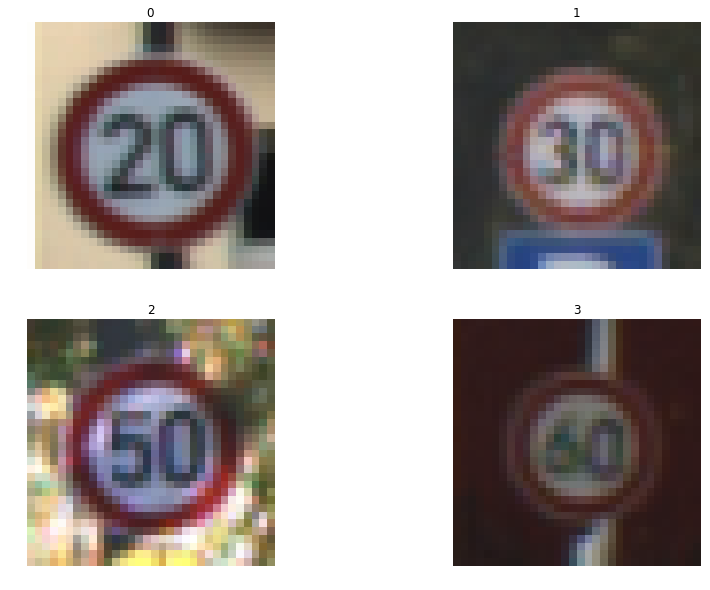

In [13]:
plot_list(sample_index[0:4], shape=(2,2))

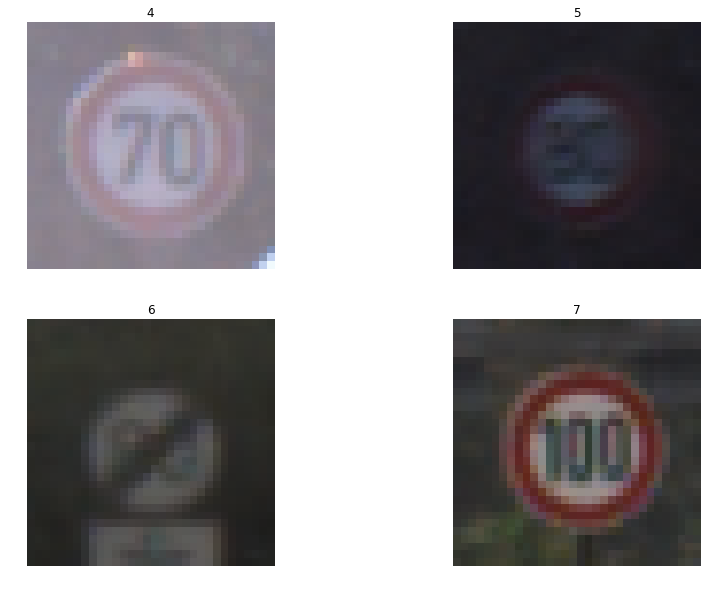

In [14]:
plot_list(sample_index[4:8], shape=(2,2))

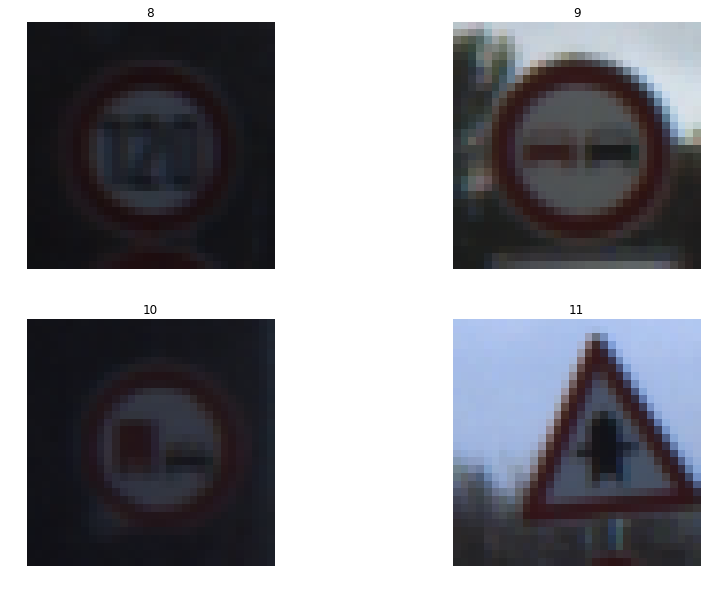

In [15]:
plot_list(sample_index[8:12], shape=(2,2))

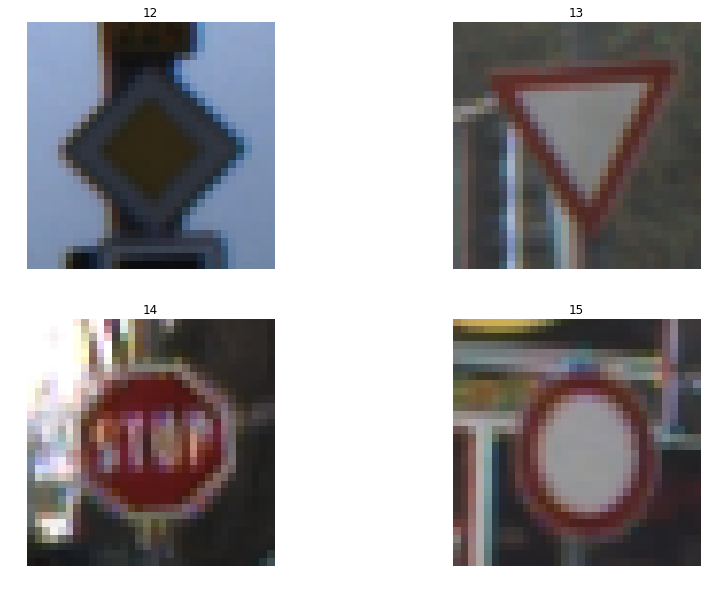

In [16]:
plot_list(sample_index[12:16], shape=(2,2))

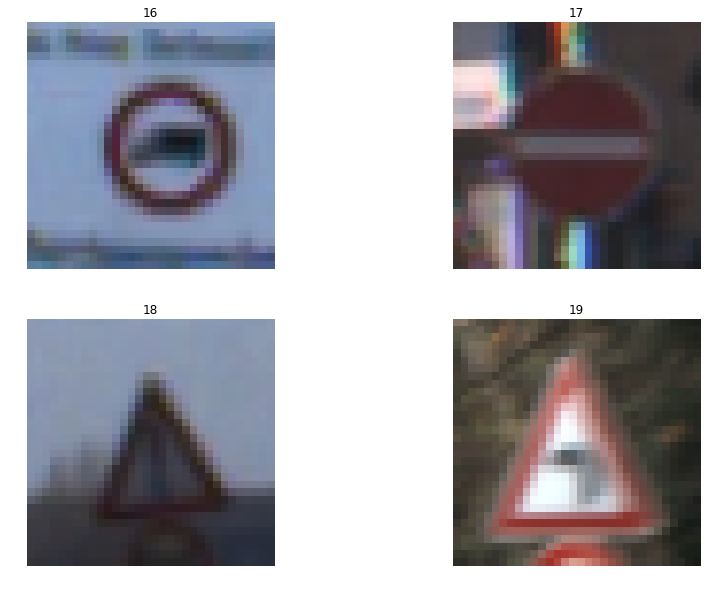

In [17]:
plot_list(sample_index[16:20], shape=(2,2))

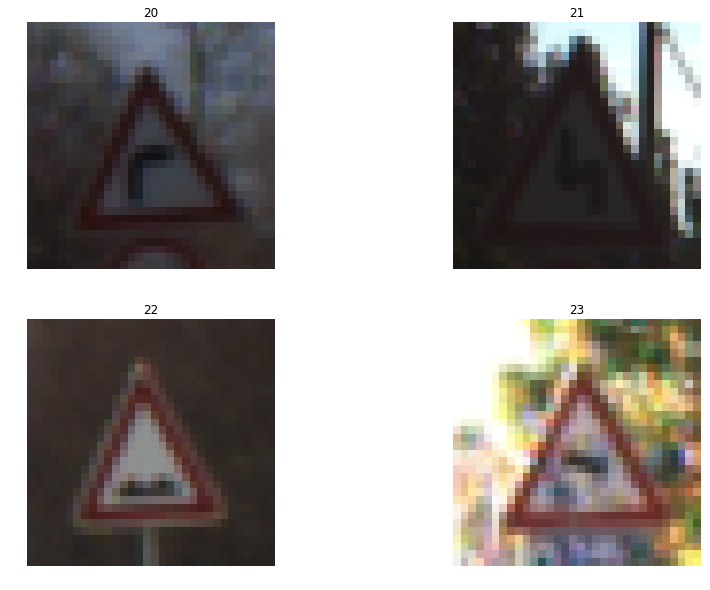

In [18]:
plot_list(sample_index[20:24], shape=(2,2))

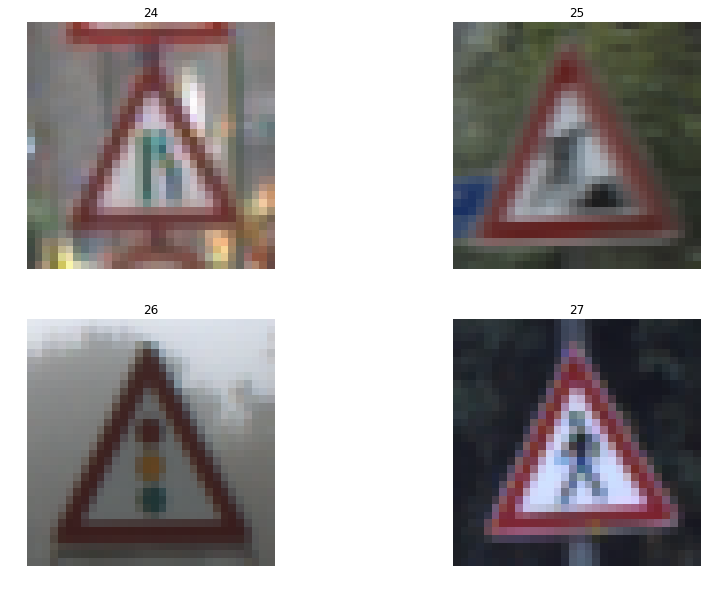

In [19]:
plot_list(sample_index[24:28], shape=(2,2))

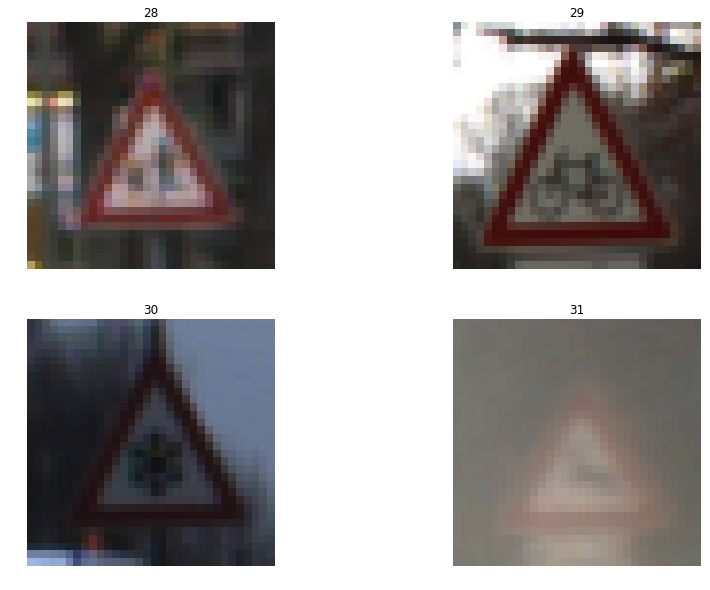

In [20]:
plot_list(sample_index[28:32], shape=(2,2))

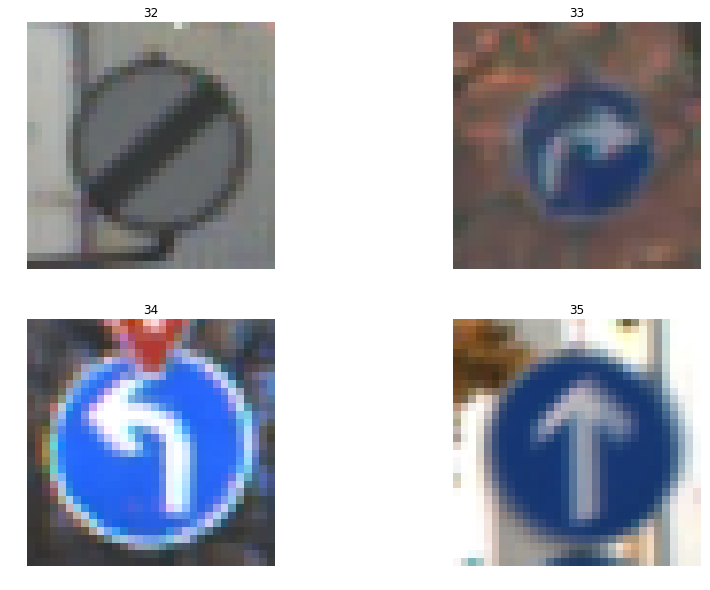

In [21]:
plot_list(sample_index[32:36], shape=(2,2))

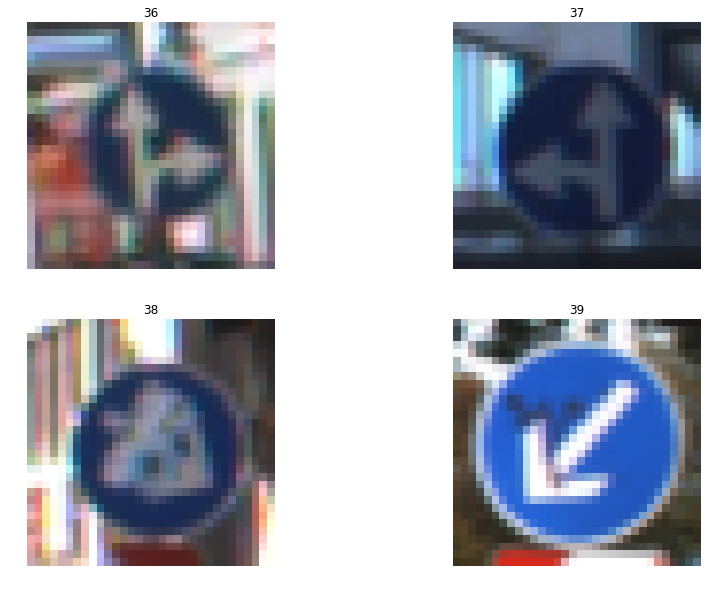

In [22]:
plot_list(sample_index[36:40], shape=(2,2))

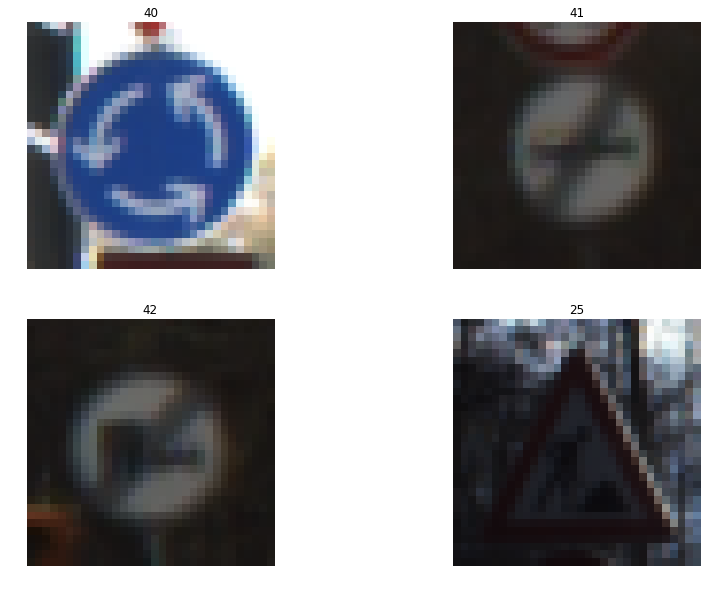

In [23]:
plot_list(sample_index[40:42] + [sample_index[42]], shape=(2,2))

In [24]:
params = do.load("/code/traffic_sign_classifier/configs.yml")

In [25]:
params.train_params.epochs = 1
params.train_params

{'buffer_size': 34799, 'batch_size': 16, 'epochs': 1}

In [26]:
def input_fn(images, labels, params, training):
    
    ds = tf.data.Dataset.from_tensor_slices((
        images,
        labels,
    ))
    
    if training:
        ds = ds.apply(tf.data.experimental.shuffle_and_repeat( 
        buffer_size = params.buffer_size,
        count = params.epochs,
        ))
        
    #ds = ds.map(lambda x, y: ({"images": x}, y))
        
    ds = ds.batch(params.batch_size, drop_remainder=True)
    
    return ds

In [27]:
ds = input_fn(train['features'], train['labels'], params.train_params, training=True)

In [28]:
ds

<BatchDataset shapes: ((16, 32, 32, 3), (16,)), types: (tf.uint8, tf.uint8)>

In [29]:
ds_iterator = ds.make_one_shot_iterator()
ds_iterops = ds_iterator.get_next()

In [30]:
def plot_batch(images, labels):
    
    fig, axes = plt.subplots(5,2, figsize=(18, 16))
    
    for index, image in enumerate(images):
        
        ax = axes[index, 0] if index < 5 else axes[index % 5, 1]
            
        ax.set_title(labels[index])
        ax.imshow(image)
        ax.set_axis_off()

In [31]:
sess = tf.Session()

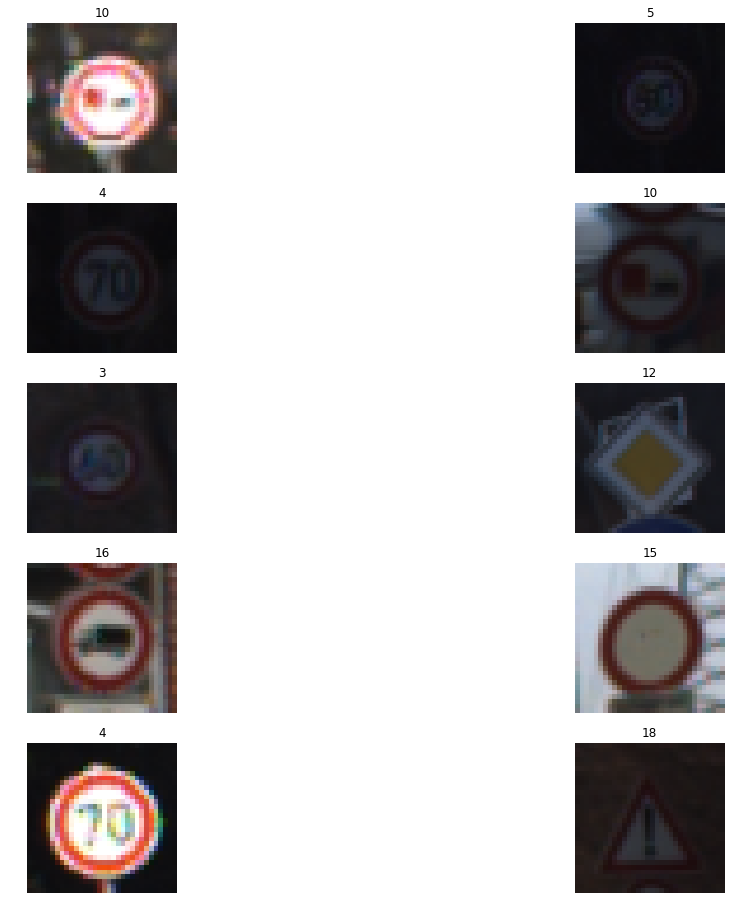

In [32]:
try:
    batch_element = sess.run(ds_iterops)
except tf.errors.OutOfRangeError:
    print("We have exhausted the dataset.")
plot_batch(*batch_element)

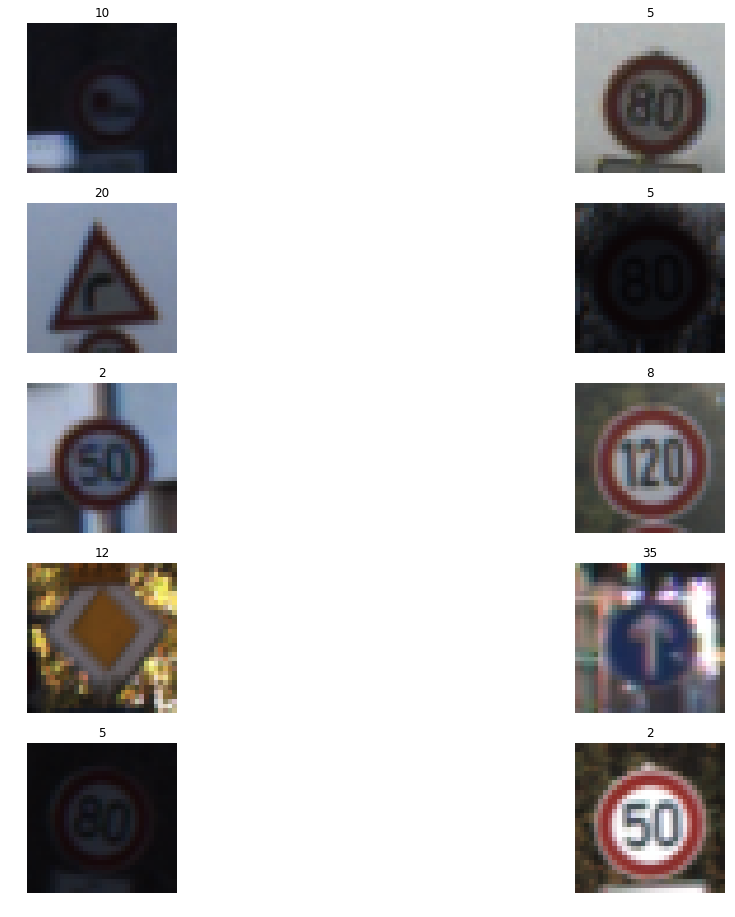

In [33]:
while True:
    try:
        batch_element = sess.run(ds_iterops)
        if 41 in batch_element[1]:
            continue
        else:
            plot_batch(*batch_element)
            break
    except tf.errors.OutOfRangeError:
        print("We have exhausted the dataset.")
        break